In [1]:
def preamble():
    print(' ')
    print('Support Vector Machines')
    print('Patrick Humphries (pvhumphr@usc.edu)')
    print('University of Southern California')
    print('INF 552 Machine Learning for Data Science (32458)')
    print('Programming Assignment 6')
    print('Spring 2020')
    print(' ')
    print('Due to the large amount of data that was provided')
    print('please wait for the first graphic to display.')
    print('Canceling the current graphic will allow the next')
    print('graphic to be displayed.')
    print(' ')
    print('In order to calculate the best accuracy with the')
    print('minimum weight values, all 1,000 iterations are run.')
    print('When the program is done, "Done!" will be displayed.')
    print(' ')


In [2]:
# import sys
# sys.path.append("C:\\Users\\Patrick\\Python_3_7_7-amd64\\Library\\bin\\mkl_rt.dll")

In [3]:
print('Loading libraries.')
import os
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split

from numpy import linalg
import cvxopt
import cvxopt.solvers


Loading libraries.


In [4]:
def determine_context():
    # The development environment (XPS) uses "monokai" theme,
    # which is dark.  It is unknown what environment is used
    # by the grader, so it reverts to default.
    logon_server = os.environ["LOGONSERVER"]
    
    if logon_server.find('XPX') == -1:
        plt.rcdefaults()
        r = plt.rcParams
    else:
        r = {"axes.edgecolor":global_text_color,
             "axes.labelcolor":global_text_color,
             "axes.facecolor":global_face_color,
             "xtick.color":global_text_color, 
             "ytick.color":global_text_color,
             "text.color":global_text_color,
             "figure.facecolor":global_face_color}
    return r


In [5]:
def load_data(file_name, test_size=0.25):
    # Load trining dataset.
    
    # Load features.
    X = np.genfromtxt(file_name, dtype=float, delimiter=',', usecols=(0,1))

    # Load correponding labels.
    y = np.genfromtxt(file_name, dtype=int, delimiter=',', usecols=2)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    print(' ')
    print('Load Data:')
    print('X_train.shape:', X_train.shape, 'y_train.shape:', y_train.shape)
    print('X_test.shape:', X_test.shape, 'y_test.shape:', y_test.shape)
     
    return (X_train, X_test, y_train, y_test)


In [6]:
from cvxopt import matrix, solvers

# minimize 2 * x1**2 + x2**2 + x1 * x2 + x1 + x2
# subject to    x1 ge 0
#               x2 ge 0
#               x1 + x2 = 1
                
if False:
    Q = 2*matrix([ [2, .5], [.5, 1] ])
    p = matrix([1.0, 1.0])
    G = matrix([[-1.0,0.0],[0.0,-1.0]])
    h = matrix([0.0,0.0])
    A = matrix([1.0, 1.0], (1,2))
    b = matrix(1.0)
    sol=solvers.qp(Q, p, G, h, A, b)
    print(sol['x'])

In [7]:
def linear_kernel(x1, x2):
    return x1@x2

In [8]:
def polynomial_kernel(x, y, p=3):
    return (1 + x@y)**p

In [9]:
def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma**2)))

In [10]:
class my_svm():
    # Adapted from Mathieu Blondel, September 2010
    
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        
        # If a soft margin is specified, 
        if self.C is not None:
            self.C = float(self.C)
            
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Multiply each features vector by all other feature vectors.
        # This satisfies the np.dot(xi, xj) part of the equation.
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        # Multiply each label vector by all other label vectors
        # Then multiply by the cross product of all features.
        # This satisfies the np.dot(yi, yj) part of the equation.
        # This results in the quadratic matrix.
        P = cvxopt.matrix(np.outer(y,y) * K)
        
        # Calculate the 
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        
        # Reshape the y vector into one row by n samples matrix.
        # Set the b matrix to zero.
        # This solves for Ax = b constraing.
        y = y.astype('d')
        A = cvxopt.matrix(y, (1,n_samples))
        print(' ')
        print('A:')
        print(A)
        b = cvxopt.matrix(0.0)

        # C is a specification for a soft margin.
        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # Solve Quadratic Programming Problem.
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)        

        # Lagrangian multipliers.
        a = np.ravel(solution['x'])

        # Create a Boolean array for identifying support vectors
        # that are mostly greater than zero.  This Boolean array
        # is used in the salections of artifacts  associated with
        # Lagrangian points.
        sv = a > 0.00001
        
        # This product results in a Boolean indicator.
        ind = np.arange(len(a))[sv]
        
        # Select Lagrangian multipliers.
        self.a = a[sv]
        
        # Select the features of Lagrangian multiplyers.
        self.sv = X[sv]
        
        # Select the labels for the Lagrangian multiplyers.
        self.sv_y = y[sv]
        
        print('\n X of size', n_samples, 'contained ', len(self.a), 'Lagrangian points.')

        # Calculate the bias.
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # If a linear kernel is being used, then calculate weights.
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None       
            
    def predict(self, X):
    
        # Initialize a vector of y predictions.
        y_predictions = np.zeros(len(X))
        
        # If the kernel were linear, then just a product of
        # features and weights plus bias.  Otherwise, use the
        # kernel to calculate the predicted y.
        if self.w is None:
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predictions[i] = s
            y_predictions = y_predictions + self.b
        else:
            y_predictions = np.dot(X, self.w) + self.b
            
        return np.sign(y_predictions), self.sv, self.sv_y, self.b, self.w


In [11]:
def plot_data(X, y, lines, title='Title'):
    
    print('Plot Data:', title)

    colors = ['red', 'black', 'green']

    # Determine display context.
    r = determine_context()
    
    # Determine features.
    X1 = X[:, 0]
    X2 = X[:, 1]
    
    # Plot the scores using the selected 
    with plt.rc_context(r):  
        ax = plt.axes()
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_title(title)
        
        for label in [1, -1]:
            # Select features based on label.
            indices = np.where(y == label)
            
            X1_plot = np.take(X1, indices)
            X2_plot = np.take(X2, indices)
            color = colors[label + 1]
            ax.scatter(X1_plot, X2_plot, color=color)

        
        X1_line = lines["X1_line_pos"]
        X2_line = lines["X2_line_pos"]
        if len(X1_line) > 0 and len(X2_line) > 0:
            ax.plot(X1_line, X2_line, color='green')
        
        X1_line = lines["X1_line_cen"]
        X2_line = lines["X2_line_cen"]
        if len(X1_line) > 0 and len(X2_line) > 0:
            ax.plot(X1_line, X2_line, color='blue')
        
        X1_line = lines["X1_line_neg"]
        X2_line = lines["X2_line_neg"]
        if len(X1_line) > 0 and len(X2_line) > 0:
            ax.plot(X1_line, X2_line, color='red')
        
        plt.show()
  

In [12]:
def calculate_lines(X_sv, y_sv, b):
    
    X1 = X_sv[:, 0].copy()
    X2 = X_sv[:, 1].copy()
    slope = 0.0

    # Initialize return values.
    lines = {
        "X1_line_pos": [],
        "X2_line_pos": [],
        "X1_line_cen": [],
        "X2_line_cen": [],
        "X1_line_neg": [],
        "X2_line_neg": []
    }
    
    # Segregate Lagranian points.
    indices = np.where(y_sv == 1.0)
    X1_pos = np.take(X1, indices)
    X1_pos = X1_pos[0]
    X2_pos = np.take(X2, indices)
    X2_pos = X2_pos[0]
    indices = np.where(y_sv == -1.0)
    X1_neg = np.take(X1, indices)
    X1_neg = X1_neg[0]
    X2_neg = np.take(X2, indices)
    X2_neg = X2_neg[0]

    # Calculate slope from positive Lagrangian points.
    if len(X2_pos) > 1:
        print('Using positive Lagrangian points.')
        X2_pos_min = np.amin(X2_pos)
        indices = np.argwhere(X2_pos == X2_pos_min)
        index = indices[0]
        X1_pos_min = X1_pos[index]
        
        X2_pos_max = np.amax(X2_pos)
        indices = np.argwhere(X2_pos == X2_pos_max)
        index = indices[0]
        X1_pos_max = X1_pos[index]
        
        # Calculate positive slope and intercept.
        slope = (X2_pos_max - X2_pos_min) / (X1_pos_max - X1_pos_min)
        b_pos = (X2_pos_min + X2_pos_max - (slope * X1_pos_min) - (slope * X1_pos_max)) / 2
        
        # Plot positive Lagrangian points.
        lines["X1_line_pos"] = [0, (1 - b_pos)/slope]
        lines["X2_line_pos"] = [b_pos, 1]
        
        # Plot negative Lagrangian points
        X1_neg_min = X1_neg[0]
        indices = np.argwhere(X1_neg == X1_neg_min)
        index = indices[0]
        X2_neg_min = X2_neg[index]
        
        X1_neg_max = X1_neg_min + 0.1
        X2_neg_max = slope * 0.1 + X2_neg_min
        
        b_neg = (X2_neg_min + X2_neg_max - (slope * X1_neg_min) - (slope * X1_neg_max)) / 2
        
        lines["X1_line_neg"] = [0, (1 - b_neg)/slope]
        lines["X2_line_neg"] = [b_neg, 1]
        
        # Plot hyperplane.
        b_cen = (b_neg + b_pos)/2
        X1_min_cen = 0
        X2_min_cen = b_cen
        X1_max_cen = X1_min_cen + 0.01
        X2_max_cen = slope * 0.01 + X2_min_cen
        
        lines["X1_line_cen"] = [0, (1 - b_cen)/slope]
        lines["X2_line_cen"] = [b_cen, 1]

        print('\n hyperplane:  X2 = ' + str(slope[0]) + ' * X1 + (' + str(b_cen[0]) + ')')
        print('  slope:', slope[0])
        print('  intercept:', b_cen[0])
        print(' ')
        
        return lines
    
    
    # Calculate slope from negative Lagrangian points.
    if len(X2_neg) > 1:
        print('Using negative Lagrangian points.')
        X2_min = np.amin(X2_neg)
        indices = np.argwhere(X2_neg == X2_min)
        index = indices[0]
        X1_min = X1_neg[index]
        
        X2_max = np.amax(X2_neg)
        indices = np.argwhere(X2_neg == X2_max)
        index = indices[0]
        X1_max = X1_neg[index]
        
        # Calculate slope and intercept.
        slope = (X2_max - X2_min) / (X1_max - X1_min)
        b_neg = (X2_min + X2_max - (slope * X1_min) - (slope * X1_max)) / 2
        
        # Plot lines for negative Lagrangian points.
        lines["X1_line_neg"] = [0, (1 - b_neg)/slope]
        lines["X2_line_neg"] = [b_neg, 1]
        
        # Plot positive Lagrangian points
        X1_pos_min = X1_pos[0]
        indices = np.argwhere(X1_pos == X1_pos_min)
        index = indices[0]
        X2_pos_min = X2_pos[index]
        
        X1_pos_max = X1_pos_min + 0.1
        X2_pos_max = slope * 0.1 + X2_pos_min
        
        b_pos = (X2_pos_min + X2_pos_max - (slope * X1_pos_min) - (slope * X1_pos_max)) / 2
        
        lines["X1_line_pos"] = [0, (1 - b_pos)/slope]
        lines["X2_line_pos"] = [b_pos, 1]
        
        # Plot hyperplane.
        b_cen = (b_neg + b_pos)/2
        X1_min_cen = 0
        X2_min_cen = b_cen
        X1_max_cen = X1_min_cen + 0.01
        X2_max_cen = slope * 0.01 + X2_min_cen
        
        lines["X1_line_cen"] = [0, (1 - b_cen)/slope]
        lines["X2_line_cen"] = [b_cen, 1]
        
        print('\n hyperplane:  X2 = ' + str(slope[0]) + ' * X1 + (' + str(b_cen[0]) + ')')
        print('  slope:', slope[0])
        print('  intercept:', b_cen[0])
        print(' ')
        
        return lines
    
    print('Not enough Lagranian points to determine slope.')
    return lines


In [13]:
def sklean_linear_classifier():
    # def sklearn_linear():
    from sklearn import svm
    X_train, X_test, y_train, y_test = load_data('linsep.txt')
    clf = svm.SVC(gamma=0.01, C=100)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(' ')
    print('sklearn_linear_classifier')
    print('score:', score)


 
Support Vector Machines
Patrick Humphries (pvhumphr@usc.edu)
University of Southern California
INF 552 Machine Learning for Data Science (32458)
Programming Assignment 6
Spring 2020
 
Due to the large amount of data that was provided
please wait for the first graphic to display.
Canceling the current graphic will allow the next
graphic to be displayed.
 
In order to calculate the best accuracy with the
minimum weight values, all 1,000 iterations are run.
When the program is done, "Done!" will be displayed.
 
 
Load Data:
X_train.shape: (75, 2) y_train.shape: (75,)
X_test.shape: (25, 2) y_test.shape: (25,)
Plot Data: Training Samples


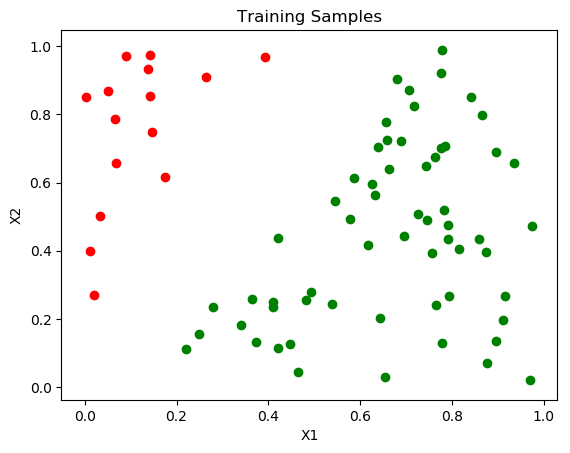

Plot Data: Testing Samples


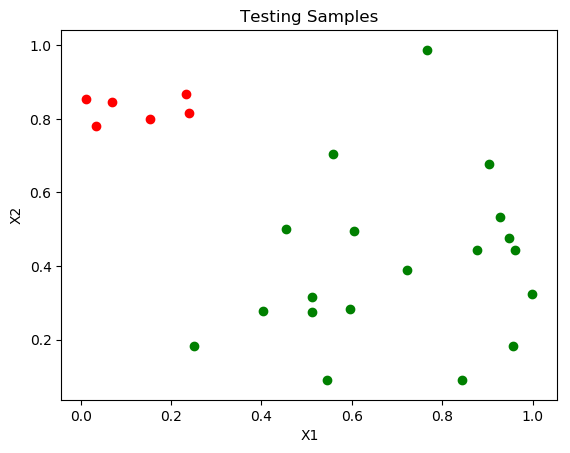

 
A:
[ 1.00e+00  1.00e+00  1.00e+00  1.00e+00  1.00e+00  1.00e+00  1.00e+00 ... ]

     pcost       dcost       gap    pres   dres
 0: -1.5792e+01 -3.5898e+01  2e+02  2e+01  2e+00
 1: -1.7363e+01 -3.4375e+01  7e+01  4e+00  5e-01
 2: -2.0470e+01 -3.5464e+01  3e+01  1e+00  1e-01
 3: -2.8030e+01 -3.7239e+01  1e+01  3e-01  3e-02
 4: -3.3429e+01 -3.3654e+01  4e-01  9e-03  1e-03
 5: -3.3595e+01 -3.3598e+01  4e-03  9e-05  1e-05
 6: -3.3597e+01 -3.3597e+01  4e-05  9e-07  1e-07
 7: -3.3597e+01 -3.3597e+01  4e-07  9e-09  1e-09
Optimal solution found.

 X of size 75 contained  3 Lagrangian points.

 accuracy: 100.0 percent.

 Lagrangian Features and Labels:
[0.27872572 0.23552777] 	 1.0
[0.3917889  0.96675591] 	 -1.0
[0.02066458 0.27003158] 	 -1.0
Using negative Lagrangian points.

 hyperplane:  X2 = 1.877334088375481 * X1 + (-0.028248135015668363)
  slope: 1.877334088375481
  intercept: -0.028248135015668363
 
Plot Data: Training Samples


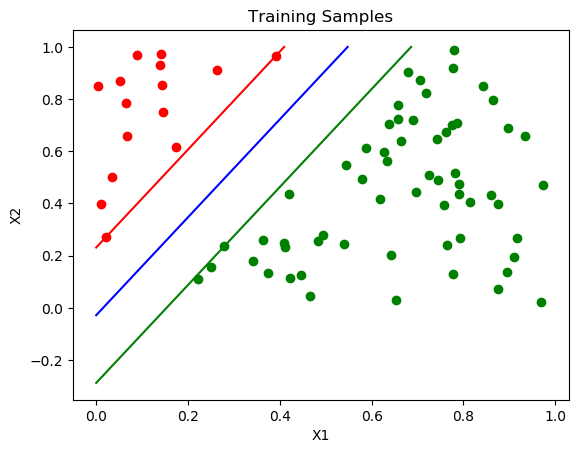

Plot Data: Testing Samples


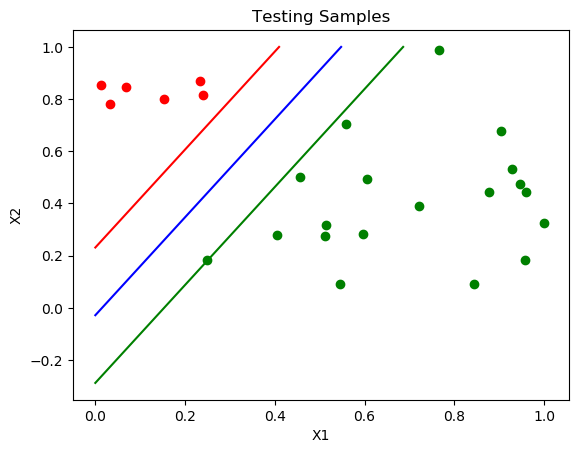

 
Load Data:
X_train.shape: (75, 2) y_train.shape: (75,)
X_test.shape: (25, 2) y_test.shape: (25,)
Plot Data: Training Samples


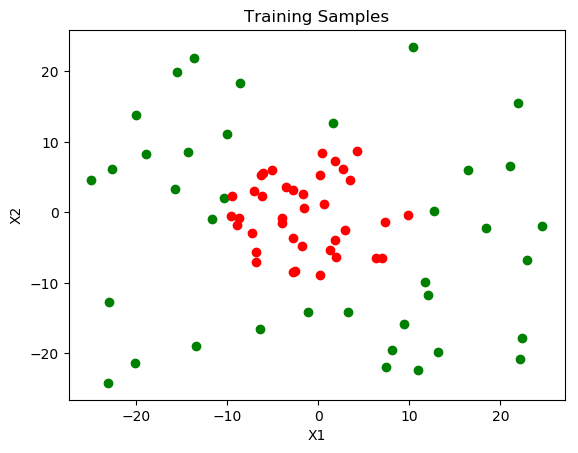

Plot Data: Testing Samples


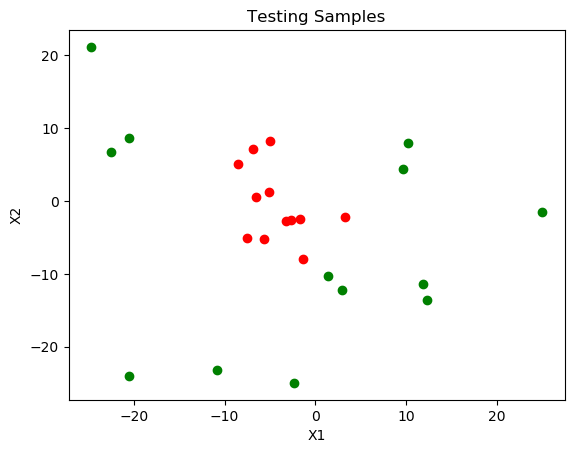

 
A:
[ 1.00e+00 -1.00e+00 -1.00e+00  1.00e+00  1.00e+00  1.00e+00 -1.00e+00 ... ]

     pcost       dcost       gap    pres   dres
 0: -1.1672e+01 -3.8354e+01  2e+02  9e+00  2e+00
 1: -1.7965e+01 -4.9179e+01  8e+01  4e+00  9e-01
 2: -5.9681e+01 -9.3667e+01  8e+01  3e+00  7e-01
 3: -9.0320e+01 -1.1670e+02  4e+01  1e+00  3e-01
 4: -9.1721e+01 -9.7109e+01  7e+00  1e-01  3e-02
 5: -9.2573e+01 -9.3161e+01  6e-01  3e-03  8e-04
 6: -9.2811e+01 -9.2884e+01  8e-02  3e-04  8e-05
 7: -9.2851e+01 -9.2859e+01  9e-03  1e-14  5e-15
 8: -9.2856e+01 -9.2856e+01  3e-04  5e-14  6e-15
 9: -9.2856e+01 -9.2856e+01  8e-06  1e-14  7e-15
Optimal solution found.

 X of size 75 contained  27 Lagrangian points.

 accuracy: 88.0 percent.

 Lagrangian Features and Labels:
[-10.02833317  11.09354511] 	 1.0
[-9.46760885  2.36139525] 	 -1.0
[12.74780931  0.19913032] 	 1.0
[-19.9566285   13.84906795] 	 1.0
[-20.08588052 -21.4203383 ] 	 1.0
[-10.260969     2.07391791] 	 1.0
[ 10.99442024 -22.39709701] 	 1.0
[-23.0396185

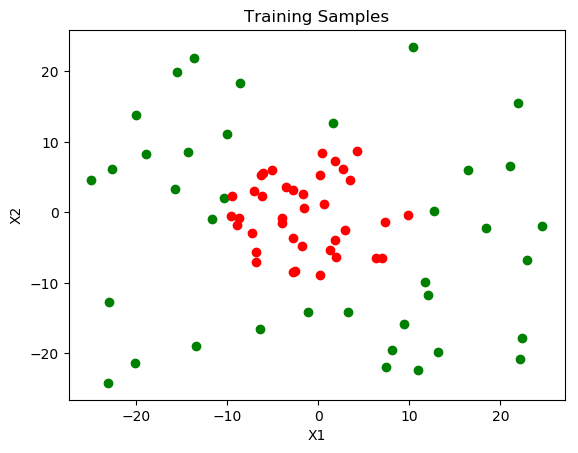

Plot Data: Testing Samples


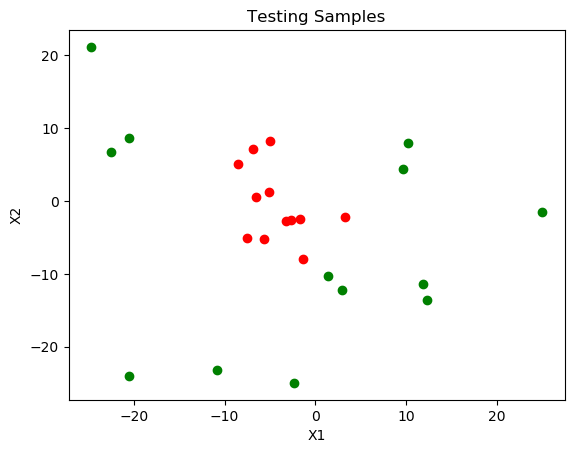

 
Load Data:
X_train.shape: (75, 2) y_train.shape: (75,)
X_test.shape: (25, 2) y_test.shape: (25,)
 
sklearn_linear_classifier
score: 1.0


In [14]:
# main
# Global Variables
global_face_color = (0.18, 0.31, 0.32)
global_text_color = "yellow"

# Display identification.
if True:
    preamble()

# Load linear data.
if True:
    X_train, X_test, y_train, y_test = load_data('linsep.txt')

# Plot linear data.
if True:
    lines = {
        "X1_line_pos": [],
        "X2_line_pos": [],
        "X1_line_cen": [],
        "X2_line_cen": [],
        "X1_line_neg": [],
        "X2_line_neg": []
    }
    plot_data(X_train, y_train, lines, 'Training Samples')
    plot_data(X_test, y_test, lines, 'Testing Samples')

# Build, fit, and test linear model.
if True:
        clf = my_svm()
        clf.fit(X_train, y_train)

        y_predictions, X_sv, y_sv, b, w = clf.predict(X_test)
        correct = np.sum(y_predictions == y_test)
        print('\n accuracy:', round((correct * 100)/len(X_test), 2), 'percent.')
#         print('\n y_predictions:', y_predictions)
        print('\n Lagrangian Features and Labels:')
        for i in range(len(X_sv)):
            print(X_sv[i], '\t', y_sv[i])
        
        # Calculate lines
        lines = calculate_lines(X_sv, y_sv, b)
#         print('lines:', lines)
        plot_data(X_train, y_train, lines, 'Training Samples')
        
        plot_data(X_test, y_test, lines, 'Testing Samples')

if True:
    X_train, X_test, y_train, y_test = load_data('nonlinsep.txt')

# Plot linear data.
if True:
    lines = {
    "X1_line_pos": [],
    "X2_line_pos": [],
    "X1_line_cen": [],
    "X2_line_cen": [],
    "X1_line_neg": [],
    "X2_line_neg": []
    }
    plot_data(X_train, y_train, lines, 'Training Samples')
    plot_data(X_test, y_test, lines, 'Testing Samples')

# Build, fit, and test linear model.
if True:
        clf = my_svm(kernel=gaussian_kernel)
        clf.fit(X_train, y_train)

        y_predictions, X_sv, y_sv, b, w = clf.predict(X_test)
        correct = np.sum(y_predictions == y_test)
        print('\n accuracy:', round((correct * 100)/len(X_test), 2), 'percent.')
        print('\n Lagrangian Features and Labels:')
        for i in range(len(X_sv)):
            print(X_sv[i], '\t', y_sv[i])
            
#         print('\n Lagrangian Labels:', y_sv)
        
        # Calculate lines
        lines = calculate_lines(X_sv, y_sv, b)
#         print('lines:', lines)
        lines = {
        "X1_line_pos": [],
        "X2_line_pos": [],
        "X1_line_cen": [],
        "X2_line_cen": [],
        "X1_line_neg": [],
        "X2_line_neg": []
        }
        plot_data(X_train, y_train, lines, 'Training Samples')
        
        plot_data(X_test, y_test, lines, 'Testing Samples')

if True:
    sklean_linear_classifier()